In [5]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 10.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import gurobipy as gp
from gurobipy import GRB

In [7]:
try:

    # Create a new model
    m = gp.Model("mip1")

    # Create variables
    x = m.addVar(vtype=GRB.BINARY, name="x")
    y = m.addVar(vtype=GRB.BINARY, name="y")
    z = m.addVar(vtype=GRB.BINARY, name="z")

    # Set objective
    m.setObjective(x + y + 2 * z, GRB.MAXIMIZE)

    # Add constraint: x + 2 y + 3 z <= 4
    # m.addConstr(x + 2 * y + 3 * z <= 4, "c0")
    constr = gp.LinExpr()
    constr += x
    constr += 2 * y
    constr += 3 * z
    constr
    m.addConstr(constr <= 4, "c0")

    # Add constraint: x + y >= 1
    m.addConstr(x + y >= 1, "c1")

    # Optimize model
    m.optimize()

    for v in m.getVars():
        print('%s %g' % (v.varName, v.x))

    print('Obj: %g' % m.objVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Set parameter Username
Set parameter LicenseID to value 2621942
Academic license - for non-commercial use only - expires 2026-02-14
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D60)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x98886187
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 3 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3

In [142]:
from gurobipy import Model, GRB

# 모델 생성
model = Model("HEMS_Optimization")

# 시간 설정
T = 24  # 24시간 시뮬레이션

# TOU 값 수정 (0.06, 0.12, 0.14만 포함)
tou_price = [0.06] * 8 + [0.12] * 1 + [0.14] * 2 + [0.12] * 1 + [0.14] * 4 + [0.14] * 6  + [0.06] * 2
# 태양광 발전량 (PV Generation)
pv_generation = [0] * 5 + [200, 500, 1000, 1500, 1800, 2000, 1800, 1500, 1000, 500, 200] + [0] * 8
# 외부 온도 (Outdoor Temperature)
outdoor_temperature = [23, 23, 23, 23, 24, 24, 27, 28, 28, 31, 31, 32, 33, 33, 32, 32, 30, 30, 29, 27, 27, 26, 25, 24]

# 주어진 변수들
T_set = 24  # 소비자 선호 온도 (24도)

E_max_AC, E_max_WM, E_max_UC = 3000, 500, 1700  # 최대 소비 전력 (Wh)
Ech_max, Edch_max = 4000, 4000  # ESS 충/방전 최대 용량
SOE_init, SOE_min, SOE_max = 2400, 800, 4000  # ESS 초기, 최소, 최대 에너지 저장량
DE_AC, DE_ESS = 40, 150  # 에너지 소비 단위 (Wh
alpha, beta = 0.8, -0.02  # AC의 온도 특성
wpref_s, wpref_f, L_WM = 6, 22, 2  # 세탁기 사용 시간 (06:00 - 22:00), 연속 2시간
penalty_k = 100  # 소비자 불편 패널티


# 변수 선언
delta_T = model.addVars(T, vtype=GRB.CONTINUOUS, name="delta_T")
T_in = model.addVars(T+1, vtype=GRB.CONTINUOUS, name="T_in")
E_AC = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, ub=E_max_AC, name="E_AC")
E_WM = model.addVars(T, vtype=GRB.BINARY, name="E_WM")  # 세탁기는 이진 변수 (0 또는 1)
SOE = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=SOE_min, ub=SOE_max, name="SOE")
E_ESS_ch = model.addVars(T, vtype=GRB.CONTINUOUS, name="E_ESS_ch")
E_ESS_dch = model.addVars(T, vtype=GRB.CONTINUOUS, name="E_ESS_dch")
E_net = model.addVars(T, vtype=GRB.CONTINUOUS, name="E_net")
E_charge = model.addVars(T, vtype=GRB.BINARY, name="E_charge") # 배터리 이진수

# 세탁기 작동 시간대 제약 이게 문제
for t in range(T):
    if t < wpref_s or t >= wpref_f:
        model.addConstr(E_WM[t] == 0)  # 선호 시간대 외에는 작동 불가

# 세탁기 총 작동 시간 제약
model.addConstr(sum(E_WM[t] for t in range(T)) == L_WM)

# 연속 작동 보장을 위한 제약 - 수정
for p in range(wpref_s, wpref_f - L_WM + 1):
    model.addConstr(sum(E_WM[t] for t in range(p, p + L_WM)) >= (E_WM[p] - E_WM[p-1]) * L_WM)

model.addConstr(T_in[0] == T_set)
model.addConstr(SOE[0] == SOE_init)
# 나머지 제약조건들
for t in range(T):
    #실내 온도 변화 모델 이게 문제
    if t > 0:
        model.addConstr(T_in[t+1] == T_in[t+1] + alpha * (outdoor_temperature[t-1] - T_in[t]) + beta * E_AC[t])
        model.addConstr(E_AC[t] - E_AC[t-1] <= DE_AC)
        model.addConstr(E_AC[t] - E_AC[t-1] >= -1*DE_AC)
    else:
        model.addConstr(T_in[t+1] == T_in[t+1] + beta * E_AC[t])
    
    # 선형화
    model.addConstr(delta_T[t] >= T_in[t+1] - T_set)
    model.addConstr(delta_T[t] >= T_set - T_in[t+1])
    
for t in range(T-1):
    # ESS 에너지 저장 모델
    model.addConstr(SOE[t+2] == SOE[t+1] + 0.9 * E_ESS_ch[t] - E_ESS_dch[t] / 0.9)
    model.addConstr(SOE[t+1] - SOE[t] <= DE_ESS)
    model.addConstr(SOE[t+1] - SOE[t] >= -1*DE_ESS)
model.addConstr(SOE[24] - SOE[23] <= DE_ESS)
model.addConstr(SOE[24] - SOE[23] >= -1*DE_ESS)


for t in range(T):
    # ESS 충/방전 제한
    model.addConstr(E_ESS_ch[t] >= 0 * E_charge[t])
    model.addConstr(E_ESS_ch[t] <= Ech_max * E_charge[t])
    model.addConstr(E_ESS_dch[t] >= 0 * (1-E_charge[t]))
    model.addConstr(E_ESS_dch[t] <= Edch_max * (1-E_charge[t]))

    # 순 전력 소비 모델 왜 이것만 들어가면 이상해지는 거지
    model.addConstr(E_AC[t] + E_WM[t] * E_max_WM + E_ESS_ch[t] - E_ESS_dch[t] - pv_generation[t] <= E_net[t])

# 목적함수 무조건 맞아
model.setObjective(
    sum(E_net[t] * tou_price[t] for t in range(T)) +  # 전기 요금 비용
    penalty_k * sum(delta_T[t] for t in range(T)),     # 온도 불편도 비용
    GRB.MINIMIZE
)

# 최적화 실행
model.optimize()

# 결과 출력
if model.status == GRB.OPTIMAL:
    print("\n최적화 성공!")
    print("\n=== 시간별 결과 ===")
    for t in range(T):
        print(f"Hour {t:2d}: delta_T = {delta_T[t].x:6.2f}°C, "
              f"E_AC = {E_AC[t].x:7.2f} Wh, "
              f"E_WM = {E_WM[t].x:1.0f}, "
              f"SOE = {SOE[t].x:7.2f} Wh")
    
    # 총 비용 계산
    total_cost = sum(E_net[t].x * tou_price[t] for t in range(T))
    print(f"\n총 전기 요금: {total_cost:.2f}")
    
    # 평균 실내 온도
    avg_temp = sum(T_in[t].x for t in range(T)) / T
    print(f"평균 실내 온도: {avg_temp:.2f}°C")
else:
    print("\n최적화 실패!")
    print(f"Status code: {model.status}")
    if model.status == GRB.INFEASIBLE:
        print("문제가 실행 불가능합니다. 제약조건을 확인해주세요.")
    elif model.status == GRB.UNBOUNDED:
        print("문제가 무한대 해를 가집니다. 제약조건을 확인해주세요.")
    else:
        print("다른 오류가 발생했습니다. Gurobi 상태 코드를 확인해주세요.")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D60)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 335 rows, 218 columns and 766 nonzeros
Model fingerprint: 0xebbd393a
Variable types: 170 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [2e-02, 4e+03]
  Objective range  [6e-02, 1e+02]
  Bounds range     [1e+00, 4e+03]
  RHS range        [2e+00, 4e+03]
Found heuristic solution: objective 12240.000000
Presolve removed 112 rows and 47 columns
Presolve time: 0.00s
Presolved: 223 rows, 171 columns, 588 nonzeros
Found heuristic solution: objective 9740.0000000
Variable types: 132 continuous, 39 integer (39 binary)

Root relaxation: objective 1.162300e+03, 86 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

   

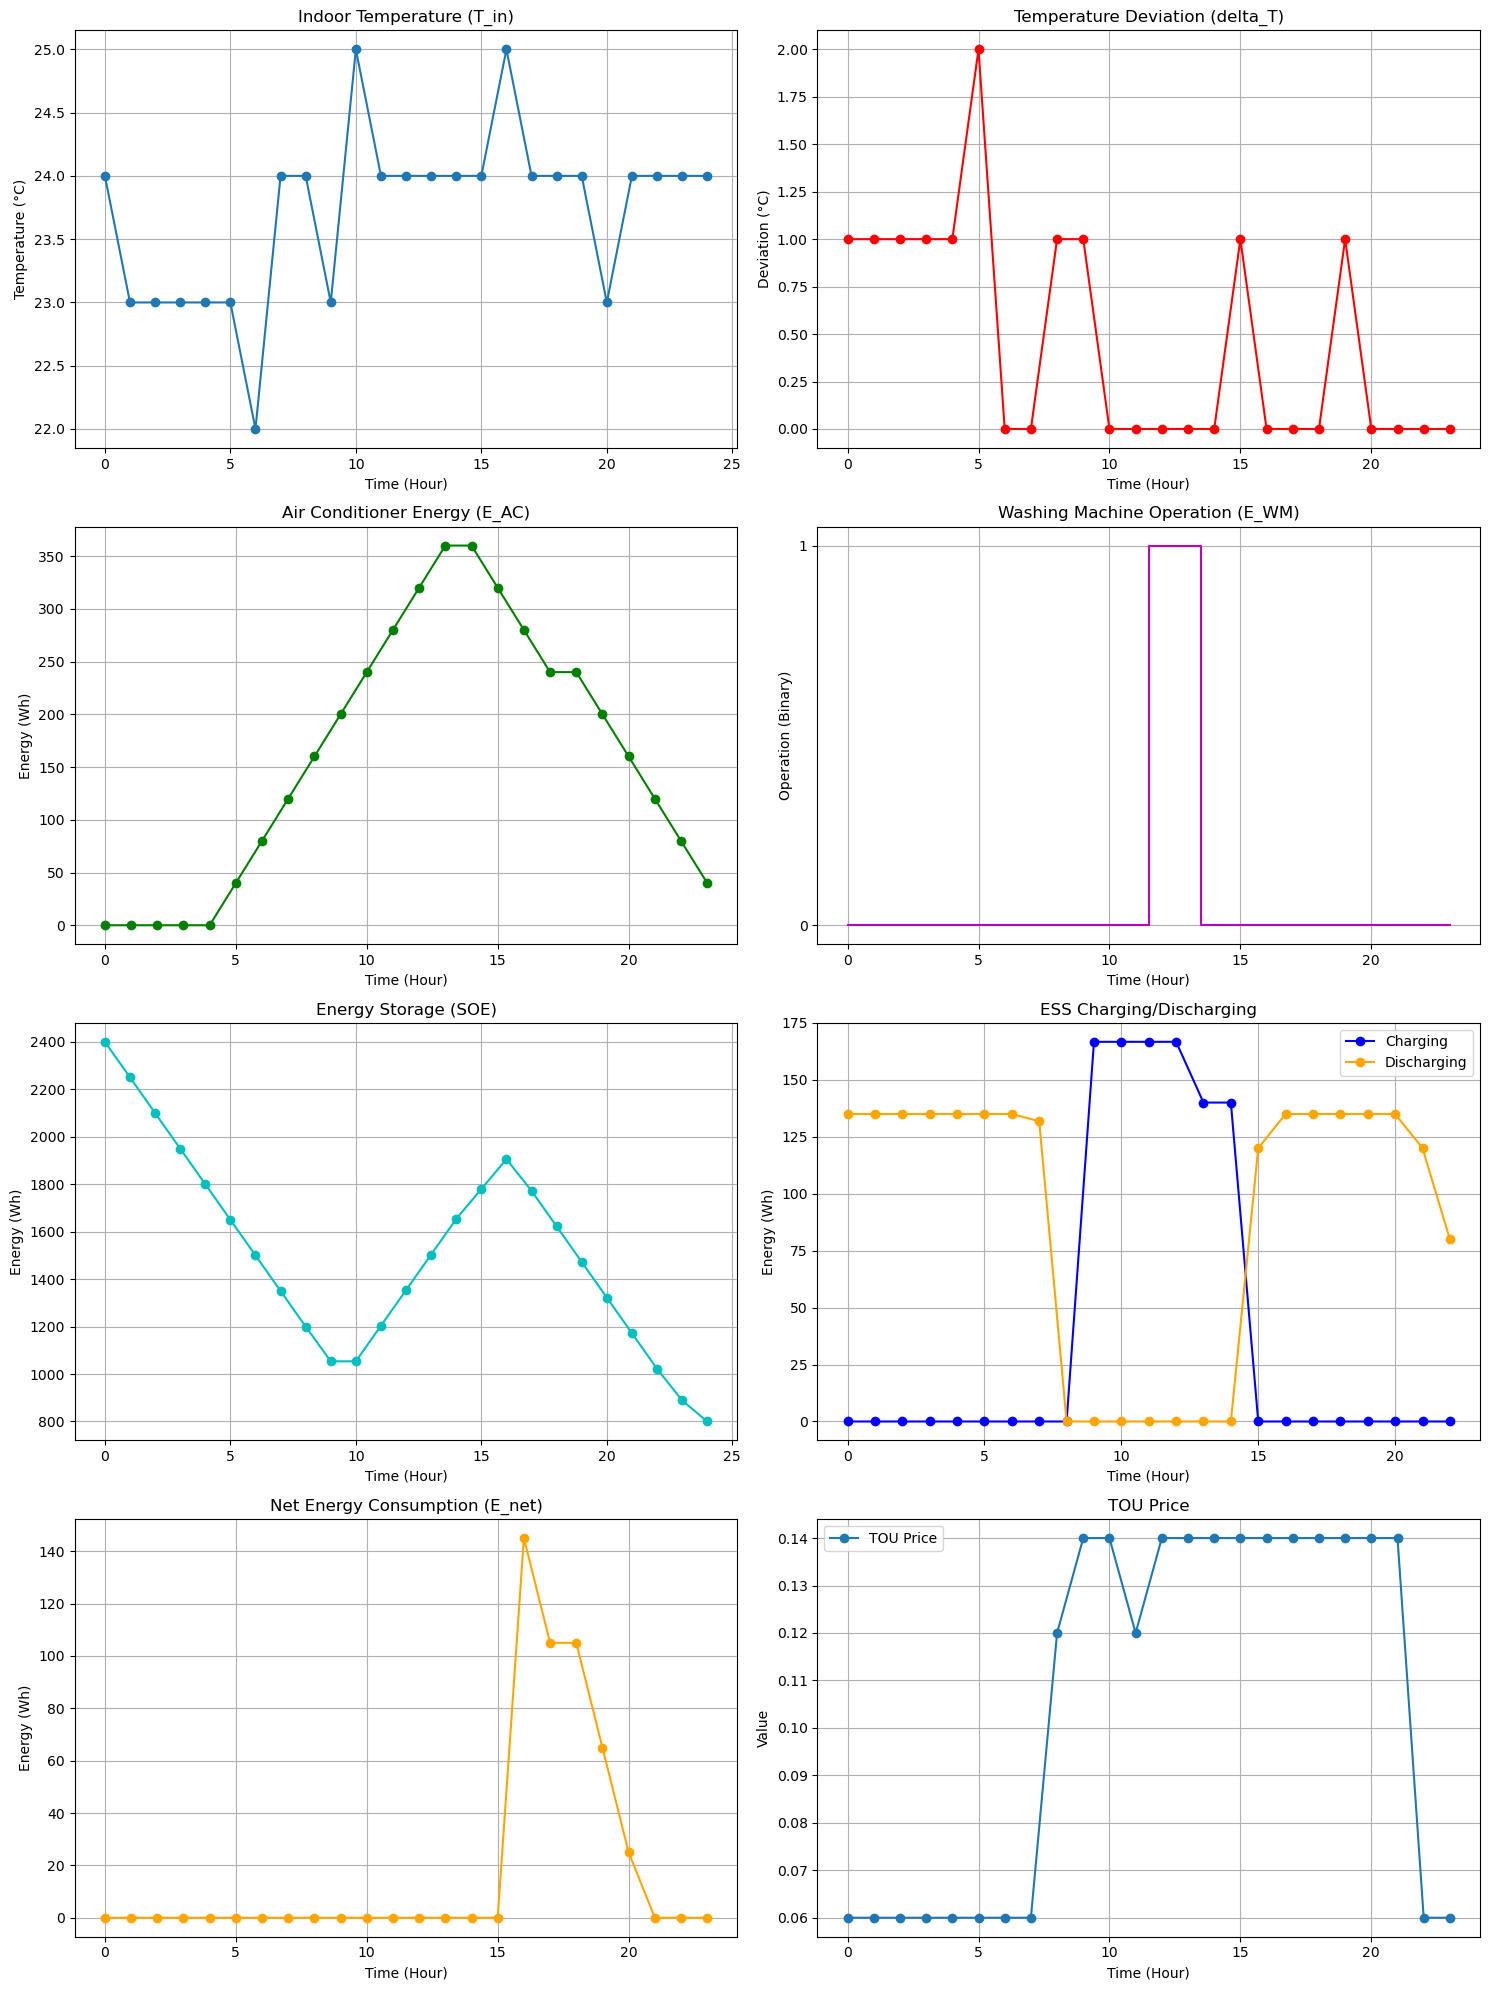

In [153]:
import matplotlib.pyplot as plt

# 최적해가 존재할 때만 시각화 (최적해를 찾지 못한 경우 메시지 출력)
if model.status == GRB.OPTIMAL:
    # 시간 인덱스 생성
    time = list(range(T))           # 0 ~ 23 (24시간)
    time_extended = list(range(T+1))  # T_in, SOE 등 초기값 포함 (0 ~ 24)
    time_low= list(range(T-1)) 
    # 최적해 값 추출 (.X 속성 사용)
    T_in_vals = [T_in[t].X for t in time_extended]
    delta_T_vals = [delta_T[t].X for t in time]
    E_AC_vals = [E_AC[t].X for t in time]
    E_WM_vals = [E_WM[t].X for t in time]
    SOE_vals = [SOE[t].X for t in time_extended]
    E_ESS_ch_vals = [E_ESS_ch[t].X for t in time_low]
    E_ESS_dch_vals = [E_ESS_dch[t].X for t in time_low]
    E_net_vals = [E_net[t].X for t in time]
    
    # 여러 서브플롯 생성 (2열 x 4행)
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    axs = axs.flatten()
    
    # 1) 실내 온도 (T_in)
    axs[0].plot(time_extended, T_in_vals, marker='o', linestyle='-')
    axs[0].set_title("Indoor Temperature (T_in)")
    axs[0].set_xlabel("Time (Hour)")
    axs[0].set_ylabel("Temperature (°C)")
    axs[0].grid(True)
    
    # 2) 온도 편차 (delta_T)
    axs[1].plot(time, delta_T_vals, marker='o', color='r', linestyle='-')
    axs[1].set_title("Temperature Deviation (delta_T)")
    axs[1].set_xlabel("Time (Hour)")
    axs[1].set_ylabel("Deviation (°C)")
    axs[1].grid(True)
    
    # 3) 에어컨 소비 전력 (E_AC)
    axs[2].plot(time, E_AC_vals, marker='o', color='g', linestyle='-')
    axs[2].set_title("Air Conditioner Energy (E_AC)")
    axs[2].set_xlabel("Time (Hour)")
    axs[2].set_ylabel("Energy (Wh)")
    axs[2].grid(True)
    
    # 4) 세탁기 작동 (E_WM) - 이진 변수이므로 계단 그래프로 표현
    axs[3].step(time, E_WM_vals, where='mid', color='m')
    axs[3].set_title("Washing Machine Operation (E_WM)")
    axs[3].set_xlabel("Time (Hour)")
    axs[3].set_ylabel("Operation (Binary)")
    axs[3].set_yticks([0, 1])
    axs[3].grid(True)
    
    # 5) ESS 에너지 저장 상태 (SOE)
    axs[4].plot(time_extended, SOE_vals, marker='o', color='c', linestyle='-')
    axs[4].set_title("Energy Storage (SOE)")
    axs[4].set_xlabel("Time (Hour)")
    axs[4].set_ylabel("Energy (Wh)")
    axs[4].grid(True)
    
    # 6) ESS 충전/방전 (E_ESS_ch, E_ESS_dch)
    axs[5].plot(time_low, E_ESS_ch_vals, marker='o', color='b', linestyle='-', label="Charging")
    axs[5].plot(time_low, E_ESS_dch_vals, marker='o', color='orange', linestyle='-', label="Discharging")
    axs[5].set_title("ESS Charging/Discharging")
    axs[5].set_xlabel("Time (Hour)")
    axs[5].set_ylabel("Energy (Wh)")
    axs[5].legend()
    axs[5].grid(True)
    
    # 7) 순 전력 소비 (E_net)
    axs[6].plot(time, E_net_vals, marker='o', color='orange', linestyle='-')
    axs[6].set_title("Net Energy Consumption (E_net)")
    axs[6].set_xlabel("Time (Hour)")
    axs[6].set_ylabel("Energy (Wh)")
    axs[6].grid(True)
    
    # 8) 추가: TOU 요금과 태양광 발전량 (옵션)
    axs[7].plot(time, tou_price, marker='o', linestyle='-', label="TOU Price")
    axs[7].set_title("TOU Price")
    axs[7].set_xlabel("Time (Hour)")
    axs[7].set_ylabel("Value")
    axs[7].legend()
    axs[7].grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("Optimal solution not found!")


In [131]:
# 세탁기 작동 시간대 제약 이게 문제
for t in range(T):
    if t < wpref_s or t >= wpref_f:
        model.addConstr(E_WM[t] == 0)  # 선호 시간대 외에는 작동 불가

# 세탁기 총 작동 시간 제약
model.addConstr(sum(E_WM[t] for t in range(T)) == L_WM)

# 연속 작동 보장을 위한 제약 - 수정
for p in range(wpref_s, wpref_f - L_WM + 1):
    model.addConstr(sum(E_WM[t] for t in range(p, p + L_WM)) >= (E_WM[p] - E_WM[p-1]) * L_WM)

# 나머지 제약조건들
for t in range(T):
    #실내 온도 변화 모델 이게 문제
    if t > 0:
        model.addConstr(T_in[t] == T_in[t-1] + alpha * (outdoor_temperature[t-1] - T_in[t-1]) + beta * E_AC[t])
        model.addConstr(E_AC[t] - E_AC[t-1] <= DE_AC)
        model.addConstr(E_AC[t] - E_AC[t-1] >= -1*DE_AC)

    else:
        model.addConstr(T_in[t] == T_set)

    # 선형화
    model.addConstr(delta_T[t] >= T_in[t] - T_set)
    model.addConstr(delta_T[t] >= T_set - T_in[t])
    
for t in range(T):
    # ESS 에너지 저장 모델
    if t > 0:
        model.addConstr(SOE[t] == SOE[t-1] + 0.9 * E_ESS_ch[t] - E_ESS_dch[t] / 0.9)
        model.addConstr(SOE[t] - SOE[t-1] <= DE_ESS)
        model.addConstr(SOE[t] - SOE[t-1] >= -1*DE_ESS)
    else:
        model.addConstr(SOE[t] == SOE_init)
    
    # ESS 충/방전 제한
    model.addConstr(E_ESS_ch[t] >= 0 * E_charge[t])
    model.addConstr(E_ESS_ch[t] <= Ech_max * E_charge[t])
    model.addConstr(E_ESS_dch[t] >= 0 * (1-E_charge[t]))
    model.addConstr(E_ESS_dch[t] <= Edch_max * (1-E_charge[t]))

    # 순 전력 소비 모델 왜 이것만 들어가면 이상해지는 거지
    #model.addConstr(E_AC[t] + E_WM[t] * E_max_WM + E_ESS_ch[t] - E_ESS_dch[t] - pv_generation[t] == E_net[t])

# 목적함수 무조건 맞아
model.setObjective(
    sum(E_net[t] * tou_price[t] for t in range(T)) +  # 전기 요금 비용
    penalty_k * sum(delta_T[t] for t in range(T)),     # 온도 불편도 비용
    GRB.MINIMIZE
)

# 최적화 실행
model.optimize()

# 결과 출력
if model.status == GRB.OPTIMAL:
    print("\n최적화 성공!")
    print("\n=== 시간별 결과 ===")
    for t in range(T):
        print(f"Hour {t:2d}: T_in = {T_in[t].x:6.2f}°C, "
              f"E_AC = {E_AC[t].x:7.2f} Wh, "
              f"E_WM = {E_WM[t].x:1.0f}, "
              f"SOE = {SOE[t].x:7.2f} Wh")
    
    # 총 비용 계산
    total_cost = sum(E_net[t].x * tou_price[t] for t in range(T))
    print(f"\n총 전기 요금: {total_cost:.2f}")
    
    # 평균 실내 온도
    avg_temp = sum(T_in[t].x for t in range(T)) / T
    print(f"평균 실내 온도: {avg_temp:.2f}°C")
else:
    print("\n최적화 실패!")
    print(f"Status code: {model.status}")
    if model.status == GRB.INFEASIBLE:
        print("문제가 실행 불가능합니다. 제약조건을 확인해주세요.")
    elif model.status == GRB.UNBOUNDED:
        print("문제가 무한대 해를 가집니다. 제약조건을 확인해주세요.")
    else:
        print("다른 오류가 발생했습니다. Gurobi 상태 코드를 확인해주세요.")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D60)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 332 rows, 216 columns and 784 nonzeros
Model fingerprint: 0x48c2f1bf
Variable types: 168 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [2e-02, 4e+03]
  Objective range  [6e-02, 1e+02]
  Bounds range     [1e+00, 4e+03]
  RHS range        [2e+00, 4e+03]
Presolve removed 83 rows and 62 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

최적화 실패!
Status code: 3
문제가 실행 불가능합니다. 제약조건을 확인해주세요.


In [73]:
[a[t] * b[t]for t in range(3)]

[2, 6, 12]

In [30]:
from gurobipy import Model, GRB

# 모델 생성
model = Model("Absolute_Value_Linearization")

# 변수 생성
x = model.addVar(lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x")
z = model.addVar(lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="z")  # 절댓값을 표현할 보조 변수

# 절댓값 선형화 제약 조건 추가
model.addConstr(x <= -5,'x_size')
model.addConstr(z >= x, "Abs_Constraint_1")
model.addConstr(z >= -x, "Abs_Constraint_2")

# 목적 함수 (예: z 최소화)
model.setObjective(z, GRB.MINIMIZE)

# 최적화 실행
model.optimize()

# 결과 출력
print(f"Optimal x: {x.x}")
print(f"Optimal |x|: {z.x}")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3 rows, 2 columns and 5 nonzeros
Model fingerprint: 0x322a55eb
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 5e+00]
Presolve removed 3 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.000000000e+00
Optimal x: -5.0
Optimal |x|: 5.0


In [ ]:
# 세탁기 작동 시간대 제약
for t in range(T):
    if t < wpref_s or t >= wpref_f:
        model.addConstr(E_WM[t] == 0)  # 선호 시간대 외에는 작동 불가

# 세탁기 연속 작동 시간 보장
model.addConstr(sum(E_WM[t] for t in range(T)) == L_WM)  # 하루 동안 총 L_WM 시간 작동

# 연속 작동 보장을 위한 제약
for t in range(wpref_s, wpref_f - L_WM + 1):
    # t시점에서 시작하는 경우 L_WM 시간 동안 연속 작동
    start = model.addVar(vtype=GRB.BINARY, name=f"start_{t}")
    model.addConstr(sum(E_WM[t + i] for i in range(L_WM)) >= L_WM * start)
    if t > wpref_s:
        model.addConstr(start <= 1 - E_WM[t-1])  # 이전 시간에 작동 중이면 시작 불가

# 나머지 제약조건들
for t in range(T):
    # 실내 온도 변화 모델
    if t > 0:
        model.addConstr(T_in[t] == T_in[t-1] + alpha * (outdoor_temperature[t-1] - T_in[t-1]) + beta * E_AC[t])
    else:
        model.addConstr(T_in[t] == T_set)
    
    # 온도 범위 제약
    model.addConstr(T_min <= T_in[t])
    model.addConstr(T_in[t] <= T_max)
    
    # 실내 온도 편차
    model.addConstr(delta_T[t] >= T_in[t] - T_set)
    model.addConstr(delta_T[t] >= T_set - T_in[t])
    
    # ESS 에너지 저장 모델
    if t > 0:
        model.addConstr(SOE[t] == SOE[t-1] + 0.9 * E_ESS_ch[t] - E_ESS_dch[t] / 0.9)
    else:
        model.addConstr(SOE[t] == SOE_init)
    
    # ESS 충/방전 제한
    model.addConstr(E_ESS_ch[t] >= 0)
    model.addConstr(E_ESS_ch[t] <= Ech_max)
    model.addConstr(E_ESS_dch[t] >= 0)
    model.addConstr(E_ESS_dch[t] <= Edch_max)
    
    # 순 전력 소비 모델
    model.addConstr(E_net[t] == E_AC[t] + E_WM[t] * E_max_WM + E_ESS_ch[t] - E_ESS_dch[t] - pv_generation[t])

In [4]:
tou_price = [0.06] * 8 + [0.12] * 1 + [0.14] * 2 + [0.12] * 1 + [0.14] * 4 + [0.14] * 6  + [0.06] * 2

[0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.06,
 0.12,
 0.14,
 0.14,
 0.12,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.14,
 0.06,
 0.06]

In [3]:
print("Feasible traffic flow: ", traffic_flow.X)

Feasible traffic flow:  30.521522259370272


In [4]:
print("Feasible PV allocation: ", ppv_grid.X, ppv_sess.X, ppv_mess.X)

Feasible PV allocation:  0.0 0.0 50.58802964996356


In [ ]:
file_ETH=pd.read_csv('/content/drive/MyDrive/ETH_USD 바이낸스 과거 데이터.csv')

file_ETH=file_ETH.drop('날짜', axis=1)
file_ETH=file_ETH.drop('변동 %', axis=1)

for i in range(len(file_ETH['종가'])):
    file_ETH['종가'][i]=float(file_ETH['종가'][i].replace(",",""))

for i in range(len(file_ETH['시가'])):
    file_ETH['시가'][i]=float(file_ETH['시가'][i].replace(",",""))

for i in range(len(file_ETH['고가'])):
    file_ETH['고가'][i]=float(file_ETH['고가'][i].replace(",",""))

for i in range(len(file_ETH['저가'])):
    file_ETH['저가'][i]=float(file_ETH['저가'][i].replace(",",""))

for i in range(len(file_ETH['거래량'])):

    if file_ETH['거래량'][i][-1]=='B':
        file_ETH['거래량'][i]=float(file_ETH['거래량'][i].replace("B",""))*1000*1000
        continue

    if file_ETH['거래량'][i][-1]=='M':
        file_ETH['거래량'][i]=float(file_ETH['거래량'][i].replace("M",""))*1000
        continue
    file_ETH['거래량'][i]=float(file_ETH['거래량'][i].replace("K",""))